In [7]:
import numpy as np
from scipy import signal as sg
from scipy.ndimage import filters, measurements as measure, morphology as morph

from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label, regionprops

import sys
sys.path.append("/home/tintin/rongheng/cv/")
from lib.image_lib import load_img, show_img, show_hist, resize_img, save_img
from lib.edge_lib import threshold, get_points, overlay_points
from lib.signal_lib import bandpass


img = load_img("bearing_scrached_fuji_tunnel.jpg") 

# Input image

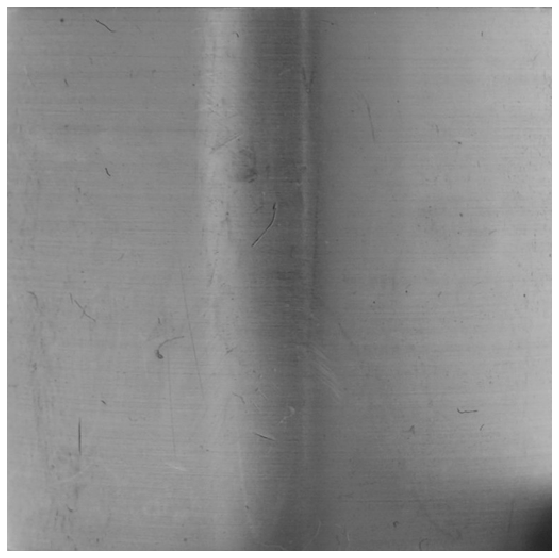

In [8]:
show_img(img, color="bw")

# Bandpass Filter

In [9]:
def bandpass_kernel(lowcut, highcut, transition, sample_frequency):
    bandpass_wavelet, length = bandpass(lowcut, highcut, transition, sample_frequency)
    bandpass_2d = np.outer(bandpass_wavelet, bandpass_wavelet)
    
    return bandpass_2d, length

Filter Length = 4001


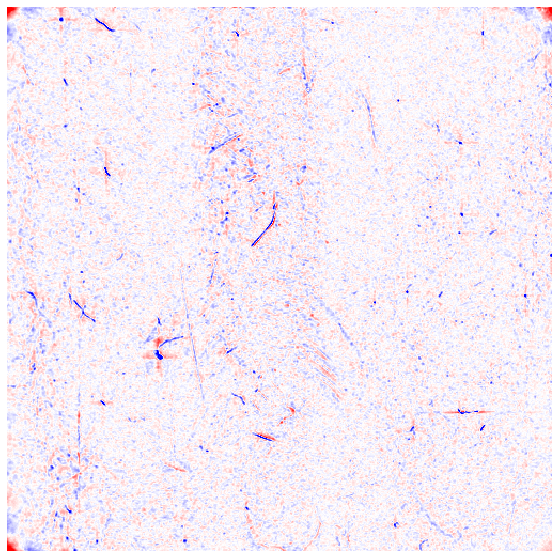

In [10]:
kernel, length = bandpass_kernel(500, 20, 1, sample_frequency=1000)
response_img = sg.convolve(kernel, img, 'full')
response_img = response_img[length:-length,length:-length]

show_img(response_img, size=(10,10), color="bwr", vmin=-20, vmax=20)

### Threshold and binary

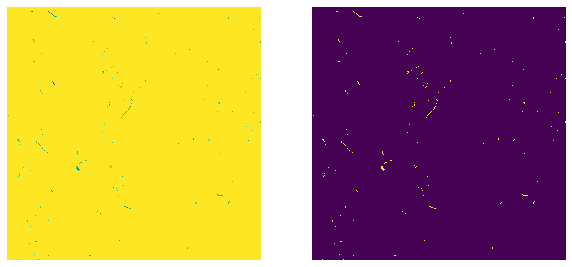

In [26]:
thresh_img = threshold(response_img, -10, invert=True)
binary_img = thresh_img.astype(bool)

show_img(thresh_img, binary_img)

# Connect neighboring regions
using first a morphological dialation to connect the neighboring regions and then skeletonizing the regions again to end up with the precise markings.

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


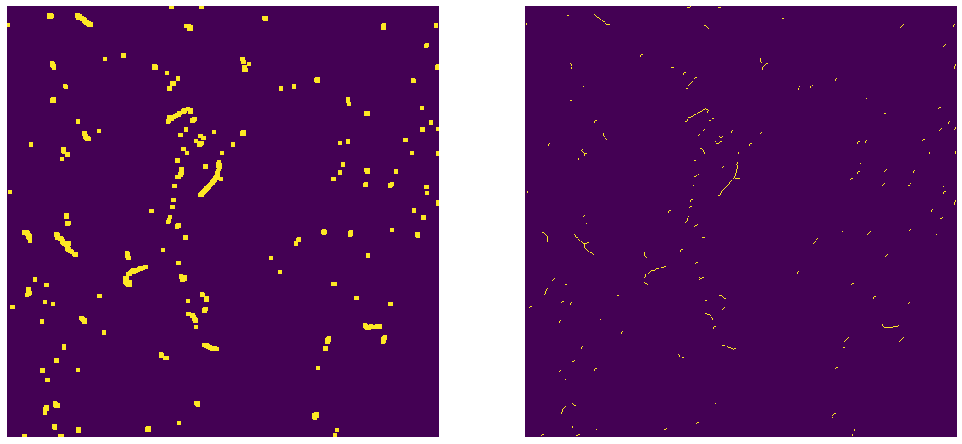

In [28]:
struct = morph.generate_binary_structure(2,2)
print(struct)

dial_img = morph.binary_dilation(binary_img, 
                                 structure=struct, iterations=2)
skeleton_img = skeletonize(dial_img,)

show_img(dial_img, skeleton_img, size=(17,17))

## Keep only the big scraches
We start by lableing all connected regions and sorting them by area (try eccentricity?). We then only keep the ones that are bigger than a certain size.

In [29]:
label_img = label(skeleton_img)
scraches_img = remove_small_objects(label_img, 17)

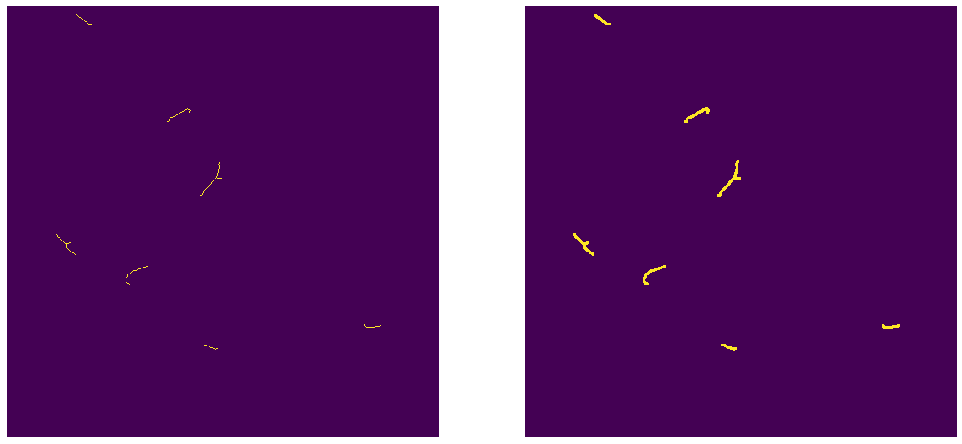

In [30]:
dial_img = morph.binary_dilation(scraches_img, structure=struct,
                                 iterations=1)
show_img(scraches_img.astype(bool), dial_img, size=(17,17))

# Points on Image
Extract the points from the result image and overlay them on the input image.

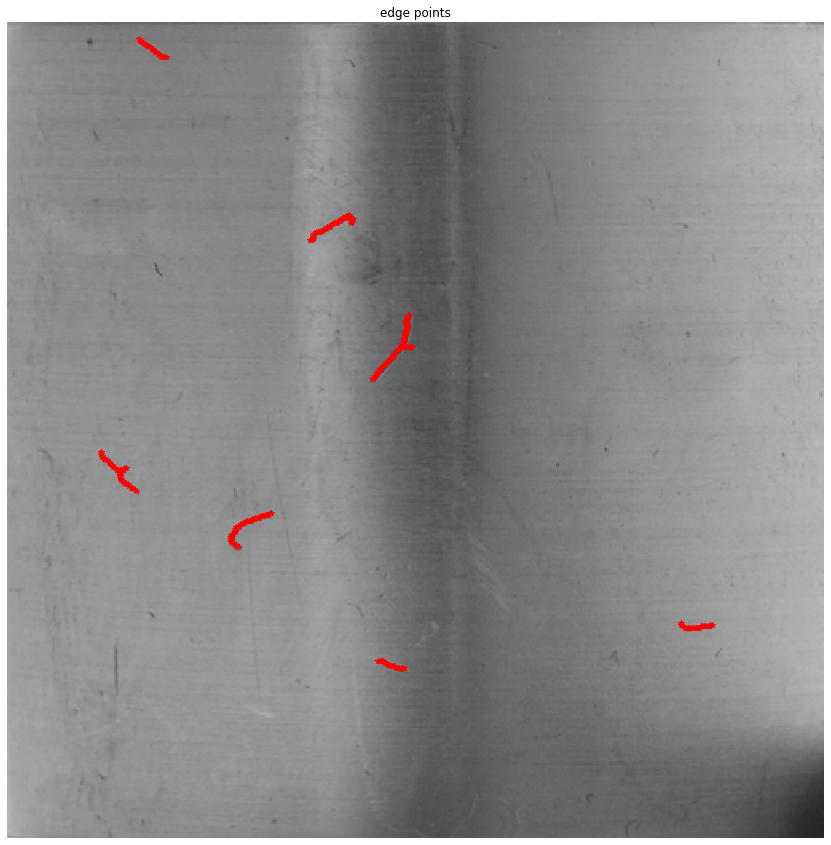

In [31]:
points = get_points(scraches_img, min_dist=10, allow_cluster=True)
overlay_points(img, points)